In [ ]:
import os
import shutil
from tensorflow.keras.utils import to_categorical
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

from matplotlib import pyplot as plt

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as k
import os
from IPython.display import Image

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**1 - Carga de imagenes**
  - Aqui separamos en carpetas los tipos de documentos que queremos considerar para el clasificador.
  - Para este ejemplo se consideraron dni español 3.0 y carnets de conducir (licensia).
  - El conjunto de imágenes se elaboró descargando documentos de prueba y realizando DataAumengtation para ampliar el dataset. El contenido del script se encuentra en el siguiente enlace: https://github.com/794866/procesamientoImagenes/blob/main/src/imageGenerator/manyFilesSource.py

  - Las imagenes han sido tratadas anteriormente para redimensionar el tamaño a escala 28x21 pixels.

#### Comentarios
- La resolución de las imágenes es demasiado baja, a la hora de detectar si tienes calidad suficiente para poder hacer la extracción se perderá mucha información. 
- ¿Por qué 28x21? Esto obliga a deformar la entrada, lo primero que habría que hacer en la imágen que nos pasan es detectar el documento y luego conseguir su bounding box. Uno de los posibles problemas es que la proporción del documento en el espacio imagen no sea la buena (ej., documento cortado por un borde) y es un buen detector de mala imagen. La red de clasificación debería ir sobre la parte en la que se ha detectado un potencial documento. 
- Las deformaciones del *data augmentation* se hacen sobre la imagen completa, ¿no? ¿Antes o después de escalar? Yo intentaría escalar el bounding box una vez detectados los candidatos en la imagen. 


((444, 400, 600, 3), (112, 400, 600, 3), (444,), (112,))

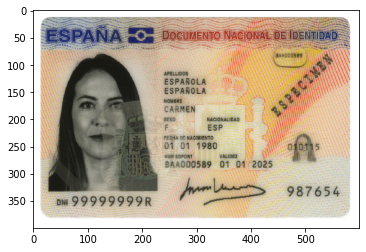

In [ ]:
img_height = 400
img_width = 600

# Ejemplo de lecturas iniciales a las que se les aplica DataAumengtation.
img = load_img("/content/gdrive/MyDrive/TFM/batches/content/dni/prueba2.png", target_size=(img_height, img_width))
plt.imshow(img)

training_paths = ["/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados2/dni_front/", "/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados2/dni_back/", "/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados2/passport/"]
validation_paths = ["/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados/dni_front_validation/", "/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados/dni_back_validation/", "/content/gdrive/MyDrive/TFM/datasets/isyc_dataset/tratados/passport_validation/"]

# Metodo para cargar imagenes inicales.
def load_images(paths):
  X = []
  y = []
  
  for path in paths:
    images_paths = os.listdir(path)
    
    for image_path in images_paths:
      complete_path = path + image_path
      image = load_img(complete_path, target_size=(img_height, img_width))
      image_array = img_to_array(image)
      X.append(image_array)
      label = paths.index(path)
      y.append(label)
  
  return X, y

X, y = load_images(training_paths)  #entrenamiento
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

#X_val, y_val = load_images(validation_paths)  #validacion

X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
#Codificacion Categorica de los resultados One-Hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape, y_val.shape

train_X,valid_X,train_label,valid_label = train_test_split(X_train, y_train, test_size=0.2, random_state=13)



In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
test_X = np.array(test_X)
test_X = test_X.astype('float32')
test_X = test_X / 255.

In [ ]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 dni_front
1 dni_back


In [ ]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  


ValueError: ignored

In [ ]:
print(X)

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (443,) (443,)
Testing data shape :  (111,) (111,)


In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

**2 - Etiquetado**
- Aqui asignamos una etiqueta a cada imagen utilizando su directorio raiz como referencia al tipo de documento, de esta forma diferenciará el clasificador el tipo de clase (tipo de documento) para una nueva entrada.
- Teniendo en cuenta que lo que se va a procesar es el color de cada pixel, se transforman las imagenes y etiquetas en arrays.

**4 - Test de entrenamiento y validacion**
- Usamos la tecnica "One-Hot Enconding" con **to_categorical()** para representar las clases [0=dni, 1=licensia]
- Subdividimos los datos en 80-20 para test y entrenamiento con **train_test_split()** y nuevamente en 80-20 el de training para obtener un subconjunto de validación.
- Preprocesamos el valor de los pixeles y lo normalizamos para que tengan un valor entre 0 y 1, por eso dividimos entre 255.
- Los arreglos de imagenes se representan con **21x28x3** para considerar imagenes a color **(x3=RGB)**. 

### **Feature Mapping**
- [Teoria mapeo de pixels](https://www.juanbarrios.com/redes-neurales-convolucionales/)
- Aplicamos el concepto de feature mapping para mapear las caracteristicas de los pixels (color).
- El analisis de los pixels se realizará mediante matrices de 3x3 denominadas kernels calculando el producto matricial de cada pixel.
- No aplicaremos 1 sólo kernel, si no que tendremos muchos kernel (32 en nuestro algoritmo) equivalentes a 32 matrices de salida de 28x21x3.
- Capa oculta 32x28x21x3 = 56448 neuronas.


#### Comentarios
- Los filtros son tan pequeños porque la imagen de entrada es muy pequeña (28x21), tienen muy poca información. 
- La resolución origen del *bounding box* que hayas detectado debería escalarse a la resolución que acepte tu red neuronal. Aunque se necesite más memoria, hay que intentar no perder información de la entrada (ojo, más tamaño en la red, obliga a mayor tamaño del dataset). 
- Me choca que se ponga una densa directamente después de una única capa de filtros convolucionales. Normalmente, se pone alguna capa de Pooling y una nueva capa de filtros, para luego al final poner una única densa y un softmax para la clasificación. 

### Feature Mapping 

In [ ]:

Image(url='https://i0.wp.com/www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn_kernel.gif')


In [ ]:
#UNA SOLA CAPA NORMALIZANDO -- ÓPTIMO
'''
epochs -> entrenamiento completo del conjunto de entrenamiento. 
Una vez que se ven todas las muestras del conjunto, comienza de nuevo, 
lo que marca el comienzo de la segunda época.
'''
INIT_LR = 1e-3
epochs = 100  #Agregar un umbral minimo para reducir el numero de epocas. 
batch_size = 100 #Tamaño del batch de imagenes a procesar (Carga en memoria).
 
clf = Sequential() #Instancia del modelo 
#Primera capa convolucional 2D con 32 filtros de tamaño 3x3
clf.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
clf.add(LeakyReLU(alpha=0.1)) #Función de activación

clf.add(Dropout(0.5))
clf.add(BatchNormalization())
 
clf.add(Flatten())
clf.add(Dense(32, activation='linear'))
clf.add(LeakyReLU(alpha=0.1))
clf.add(Dropout(0.5)) 
clf.add(Dense(nClasses, activation='softmax'))
 
clf.summary()
 
clf.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

clf_train_dropout = clf.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#clf.save("firstModel_mnist.h5py")


test_eval = clf.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 21, 28, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 21, 28, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 21, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 18816)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                602144    
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


39/39 [==============================] - 4s 86ms/step - loss: 0.6245 - accuracy: 0.6946 - val_loss: 0.6059 - val_accuracy: 0.6184
Epoch 2/100
39/39 [==============================] - 3s 81ms/step - loss: 0.4579 - accuracy: 0.7951 - val_loss: 0.5631 - val_accuracy: 0.7442
Epoch 3/100
39/39 [==============================] - 3s 81ms/step - loss: 0.3961 - accuracy: 0.8339 - val_loss: 0.5311 - val_accuracy: 0.8470
Epoch 4/100
39/39 [==============================] - 3s 81ms/step - loss: 0.3410 - accuracy: 0.8549 - val_loss: 0.4679 - val_accuracy: 0.8512
Epoch 5/100
39/39 [==============================] - 3s 82ms/step - loss: 0.3063 - accuracy: 0.8709 - val_loss: 0.4409 - val_accuracy: 0.8983
Epoch 6/100
39/39 [==============================] - 3s 81ms/step - loss: 0.2763 - accuracy: 0.8974 - val_loss: 0.3998 - val_accuracy: 0.9214
Epoch 7/100
39/39 [==============================] - 3s 81ms/step - loss: 0.2581 - accuracy: 0.8987 - val_loss: 0.3157 - val_accuracy: 0.8994
Epoch 8/100
39/39 

###**Funcion para pintar valores de funcion de perdida y precisión del clasificador entrenado**

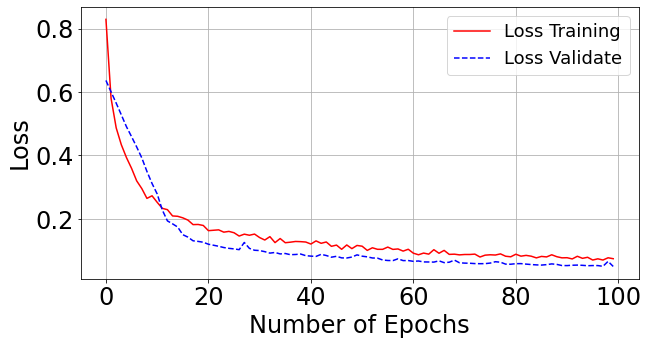

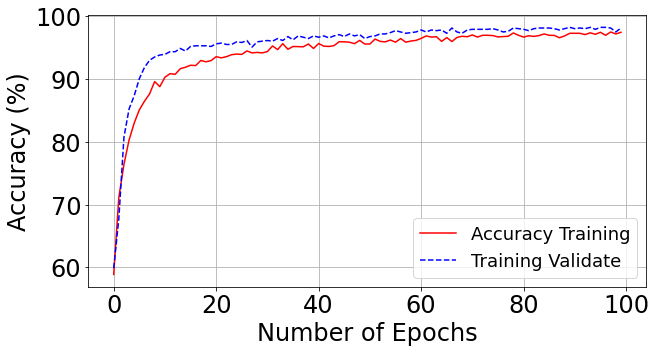

In [ ]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

plotTraining(clf_train_dropout,epochs,"loss")
plotTraining(clf_train_dropout,epochs,"accuracy")
plotTraining(clf_train_dropout,epochs,"val_loss")
plotTraining(clf_train_dropout,epochs,"val_accuracy")

###**PROBANDO EL MODELO**

dni


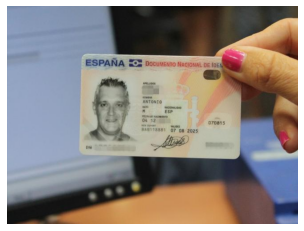

licensia


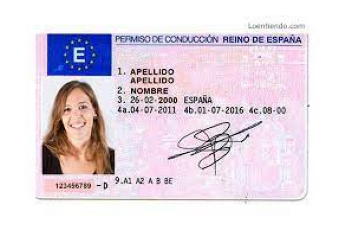

In [ ]:
path = "/content/gdrive/MyDrive/3rd year/TFM/desarrollo/content/"
#sport_model.save(path+"firstModel_mnist.h5py")

names = ['dni','licensia']

modelt = load_model("firstModel_mnist.h5py")
#modelt = custom_vgg_model

#Esta imagen no forma parte del dataset
imaget_path = path+"prueba/dni.jpg"
img = cv2.imread(imaget_path)
imaget=cv2.resize(cv2.imread(imaget_path), (28, 21), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(img),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

imaget_path = path+"prueba/licensia.jpeg"
img = cv2.imread(imaget_path)
imaget=cv2.resize(cv2.imread(imaget_path), (28, 21), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(img),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/3rd year/TFM/desarrollo/content/firstModel_mnist.h5py/assets
